In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime
import plotly.express as px
import sklearn

from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from warnings import simplefilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import xgboost as xgb

import eli5 # Feature importance evaluation

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

from sklearn.metrics import make_scorer
from xgboost import plot_importance

C:\Users\alexs\.conda\envs\Alex_R\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

C:\Users\alexs\.conda\envs\Alex_R\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.
C:\Users\alexs\.conda\envs\Alex_R\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

In [2]:
#Definimos el concepto de tn, tp, fn y fp en una matriz de confusión binaria para poder extraerlos en cada iteración del CV:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

# 9. Adaboost

### 9.1 Definimos dataset

In [3]:
#Importamos el dataset final
df_final = pd.read_csv("df_final.csv")

In [4]:
df_final.shape

(70349, 23)

### 9.2 Reducir atributos

En este apartado vamos ver cuales son los atributos mas importantes para el modelo. Con esta información podremos ver si el modelo con menos variables es igual de bueno o no. De esta manera tendremos un atributo mucho mas simple y rapido.

Empezamos teniendo los 22 atributos iniciales.

In [6]:
#Definimos que variables son númericas y cuales son categóricas:
num_features = ["lead_time","arrival_date_week_number", "arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","agent","adr","required_car_parking_spaces","total_of_special_requests",
               ]
,
cat_features = ["arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","customer_type"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Prepararamos el preprocesado. Escalaremos las variables numéricas y codificaremos las variables categóricas:
num_transformer = StandardScaler()
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
#Definimos el modelo a usar:
ab_model = AdaBoostClassifier()

#Usaremos 10-fold stratified CV. Al usar pipelines nos aseguramos que los datos se transformen en cada iteración.
kfold = KFold(n_splits=10, random_state=100, shuffle = True)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', ab_model)])
cv_results = cross_validate(model_pipe, 
                                 X_train, y_train, 
                                 cv=kfold,
                                 scoring={'accuracy': 'accuracy','balanced_accuracy': 'balanced_accuracy','roc_auc': 'roc_auc','tp': make_scorer(tp), 'tn': make_scorer(tn),
'fp': make_scorer(fp), 'fn': make_scorer(fn)},
                                 n_jobs=-1)
#Mostramos los resultados:
model_results_ab22 = np.zeros(shape=(1,7))
accuracy_array =  cv_results['test_accuracy']
balanced_accuracy_array =  cv_results['test_balanced_accuracy']
roc_auc_array = cv_results['test_roc_auc']


min_score_acc = round(min(accuracy_array), 4)
max_score_acc = round(max(accuracy_array), 4)
mean_score_acc = round(np.mean(accuracy_array), 4)
std_dev_acc = round(np.std(accuracy_array), 4)

min_score_bal_acc = round(min(balanced_accuracy_array), 4)
max_score_bal_acc = round(max(balanced_accuracy_array), 4)
mean_score_bal_acc = round(np.mean(balanced_accuracy_array), 4)
std_dev_bal_acc = round(np.std(balanced_accuracy_array), 4)

min_score_roc_auc = round(min(roc_auc_array), 4)
max_score_roc_auc = round(max(roc_auc_array), 4)
mean_score_roc_auc = round(np.mean(roc_auc_array), 4)
std_dev_roc_auc = round(np.std(roc_auc_array), 4)

sensitivity = np.zeros(shape=(1,10))
specificity = np.zeros(shape=(1,10))
precision = np.zeros(shape=(1,10))
NPV = np.zeros(shape=(1,10))
FNR = np.zeros(shape=(1,10))
FPR = np.zeros(shape=(1,10))
F1 = np.zeros(shape=(1,10))

#Construimos la matriz de confusión:
cm_ab22 = np.zeros(shape=(2,2))

tp_array = cv_results['test_tp']
tn_array = cv_results['test_tn']
fp_array = cv_results['test_fp']
fn_array = cv_results['test_fn']
    
tn_mean = (tn_array.mean()).astype(np.int64)
fp_mean = (fp_array.mean()).astype(np.int64)
fn_mean = (fn_array.mean()).astype(np.int64)
tp_mean = (tp_array.mean()).astype(np.int64)

cm_ab22[0] = [tn_mean, fp_mean]
cm_ab22[1] = [fn_mean, tp_mean]

j=0
while j < 10:
    sensitivity[0,j] = tp_array[j]/(tp_array[j]+fn_array[j])
    specificity[0,j] = tn_array[j]/(tn_array[j]+fp_array[j])
    precision[0,j] = tp_array[j]/(tp_array[j]+fp_array[j])
    NPV[0,j] = tn_array[j]/(tn_array[j]+fn_array[j])
    FNR[0,j] = 1-tp_array[j]/(tp_array[j]+fn_array[j])
    FPR[0,j] = 1-tn_array[j]/(tn_array[j]+fp_array[j])
    F1[0,j] = 2*tp_array[j]/(2*tp_array[j]+fp_array[j]+fn_array[j])
    j=j+1
    
        
sd_sensitivity = round(np.std(sensitivity), 4)
sd_specificity = round(np.std(specificity), 4)
sd_precision = round(np.std(precision), 4)
sd_NPV = round(np.std(NPV), 4)
sd_FNR = round(np.std(FNR), 4)
sd_FPR = round(np.std(FPR), 4)
sd_F1 = round(np.std(F1), 4)
    
sensitivity_mean = round(sensitivity.mean(),4)
specificity_mean = round(specificity.mean(),4)
precision_mean = round(precision.mean(),4)
NPV_mean = round(NPV.mean(),4)
FNR_mean = round(FNR.mean(),4)
FPR_mean = round(FPR.mean(),4)
F1_mean = round(F1.mean(),4)


model_results_ab22 = np.array([mean_score_acc,mean_score_bal_acc,mean_score_roc_auc,tn_mean,fp_mean,fn_mean,tp_mean])

print(f"Adaboost accuracy score: {mean_score_acc} +/- {std_dev_acc} (std) min: {min_score_acc}, max: {max_score_acc}")
print(f"Adaboost balanced accuracy score: {mean_score_bal_acc} +/- {std_dev_bal_acc} (std) min: {min_score_bal_acc}, max: {max_score_bal_acc}")
print(f"Adaboost area under ROC curve score: {mean_score_roc_auc} +/- {std_dev_roc_auc} (std) min: {min_score_roc_auc}, max: {max_score_roc_auc}")
print(f"Adaboost cross validation sensitivity score: {sensitivity_mean} +/- {sd_sensitivity} (std)")
print(f"Adaboost cross validation specificity score: {specificity_mean} +/- {sd_specificity} (std)")
print(f"Adaboost cross validation precision score: {precision_mean} +/- {sd_precision} (std)")
print(f"Adaboost cross validation NPV score: {NPV_mean} +/- {sd_NPV} (std)")
print(f"Adaboost cross validation FNR score: {FNR_mean} +/- {sd_FNR} (std)")
print(f"Adaboost cross validation FPR score: {FPR_mean} +/- {sd_FPR} (std)")
print(f"Adaboost cross validation F1 score: {F1_mean} +/- {sd_F1} (std)")
print(cm_ab22)

Adaboost accuracy score: 0.8113 +/- 0.0066 (std) min: 0.8027, max: 0.8256
Adaboost balanced accuracy score: 0.8026 +/- 0.0074 (std) min: 0.7917, max: 0.8189
Adaboost area under ROC curve score: 0.8935 +/- 0.0055 (std) min: 0.8823, max: 0.9023
Adaboost cross validation sensitivity score: 0.7381 +/- 0.0129 (std)
Adaboost cross validation specificity score: 0.8672 +/- 0.009 (std)
Adaboost cross validation precision score: 0.8091 +/- 0.0137 (std)
Adaboost cross validation NPV score: 0.8127 +/- 0.0071 (std)
Adaboost cross validation FNR score: 0.2619 +/- 0.0129 (std)
Adaboost cross validation FPR score: 0.1328 +/- 0.009 (std)
Adaboost cross validation F1 score: 0.7719 +/- 0.0104 (std)
[[2075.  318.]
 [ 478. 1348.]]


Miraremos ahora la importancia de los atributos:

In [7]:
#Ajustamos el modelo para poder acceder a los valores:
model_pipe.fit(X_train,y_train)

#Necesitamos los nombres de los atributos codificados. Los obtenemos de One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#Añadimos los atributos numéricos para tener la lista de atributos completa
feat_imp_list = num_features + onehot_columns

#Calculamos la importancia de cada variable:
feature_importances = model_pipe['model'].feature_importances_

# variable importance: 
imp = {"VarName":feat_imp_list
       , "Importance":feature_importances}


imp_df_raw = pd.DataFrame(imp)

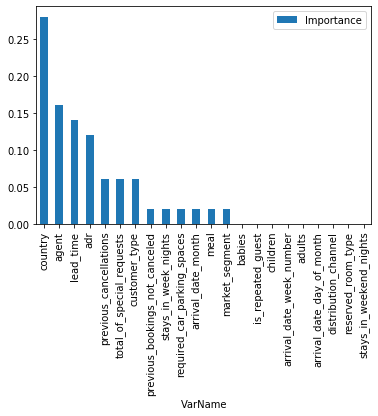

In [9]:
#Construimos un primer dataframe con las variables numéricas:
search_values = num_features
imp_df_num = imp_df_raw[imp_df_raw.VarName.str.contains('|'.join(search_values ))].copy()

#Juntamos todas las categorías de las variables categóricas:

arrival_date_month = imp_df_raw[imp_df_raw['VarName'].str.contains("arrival_date_month")]
meal = imp_df_raw[imp_df_raw['VarName'].str.contains("meal")]
country = imp_df_raw[imp_df_raw['VarName'].str.contains("country")]
market_segment = imp_df_raw[imp_df_raw['VarName'].str.contains("market_segment")]
distribution_channel = imp_df_raw[imp_df_raw['VarName'].str.contains("distribution_channel")]
reserved_room_type = imp_df_raw[imp_df_raw['VarName'].str.contains("reserved_room_type")]
customer_type = imp_df_raw[imp_df_raw['VarName'].str.contains("customer")]

#Creamos un array con las sumas:
array = np.zeros(shape=(7,1))
array[0] = arrival_date_month.Importance.sum()
array[1] = meal.Importance.sum()
array[2] = country.Importance.sum()
array[3] = market_segment.Importance.sum()
array[4] = distribution_channel.Importance.sum()
array[5] = reserved_room_type.Importance.sum()
array[6] = customer_type.Importance.sum()

#Construimos un diccionario para crear un dataframe con las variables categóricas fácilmente:
dict = {'VarName': [
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'customer_type']
                 , 'Importance': array[:,0]}

imp_dict = pd.DataFrame(dict)

#Unimos los dos dataframes:
imp_df_final = imp_df_num.append(imp_dict,ignore_index = True)
imp_df_final.head(22)
imp_df_final.sort_values(by = 'Importance', ascending=False).head(22).plot.bar(x = 'VarName')

Probaremos a eliminar las 9 variables que son 0 o casi. Quedandonos asi con 13 atributos

In [12]:
#Definimos que variables son númericas y cuales son categóricas:
num_features = ["lead_time","stays_in_week_nights","previous_cancellations","previous_bookings_not_canceled","agent","adr","required_car_parking_spaces","total_of_special_requests",
               ]
,
cat_features = ["arrival_date_month","meal","country","market_segment","customer_type"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Prepararamos el preprocesado. Escalaremos las variables numéricas y codificaremos las variables categóricas:
num_transformer = StandardScaler()
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
#Definimos el modelo a usar:
ab_model = AdaBoostClassifier()

#Usaremos 10-fold stratified CV. Al usar pipelines nos aseguramos que los datos se transformen en cada iteración.
kfold = KFold(n_splits=10, random_state=100, shuffle = True)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', ab_model)])
cv_results = cross_validate(model_pipe, 
                                 X_train, y_train, 
                                 cv=kfold,
                                 scoring={'accuracy': 'accuracy','balanced_accuracy': 'balanced_accuracy','roc_auc': 'roc_auc','tp': make_scorer(tp), 'tn': make_scorer(tn),
'fp': make_scorer(fp), 'fn': make_scorer(fn)},
                                 n_jobs=-1)
#Mostramos los resultados:
model_results_ab13 = np.zeros(shape=(1,7))
accuracy_array =  cv_results['test_accuracy']
balanced_accuracy_array =  cv_results['test_balanced_accuracy']
roc_auc_array = cv_results['test_roc_auc']


min_score_acc = round(min(accuracy_array), 4)
max_score_acc = round(max(accuracy_array), 4)
mean_score_acc = round(np.mean(accuracy_array), 4)
std_dev_acc = round(np.std(accuracy_array), 4)

min_score_bal_acc = round(min(balanced_accuracy_array), 4)
max_score_bal_acc = round(max(balanced_accuracy_array), 4)
mean_score_bal_acc = round(np.mean(balanced_accuracy_array), 4)
std_dev_bal_acc = round(np.std(balanced_accuracy_array), 4)

min_score_roc_auc = round(min(roc_auc_array), 4)
max_score_roc_auc = round(max(roc_auc_array), 4)
mean_score_roc_auc = round(np.mean(roc_auc_array), 4)
std_dev_roc_auc = round(np.std(roc_auc_array), 4)

sensitivity = np.zeros(shape=(1,10))
specificity = np.zeros(shape=(1,10))
precision = np.zeros(shape=(1,10))
NPV = np.zeros(shape=(1,10))
FNR = np.zeros(shape=(1,10))
FPR = np.zeros(shape=(1,10))
F1 = np.zeros(shape=(1,10))

#Construimos la matriz de confusión:
cm_ab13 = np.zeros(shape=(2,2))

tp_array = cv_results['test_tp']
tn_array = cv_results['test_tn']
fp_array = cv_results['test_fp']
fn_array = cv_results['test_fn']
    
tn_mean = (tn_array.mean()).astype(np.int64)
fp_mean = (fp_array.mean()).astype(np.int64)
fn_mean = (fn_array.mean()).astype(np.int64)
tp_mean = (tp_array.mean()).astype(np.int64)

cm_ab13[0] = [tn_mean, fp_mean]
cm_ab13[1] = [fn_mean, tp_mean]

j=0
while j < 10:
    sensitivity[0,j] = tp_array[j]/(tp_array[j]+fn_array[j])
    specificity[0,j] = tn_array[j]/(tn_array[j]+fp_array[j])
    precision[0,j] = tp_array[j]/(tp_array[j]+fp_array[j])
    NPV[0,j] = tn_array[j]/(tn_array[j]+fn_array[j])
    FNR[0,j] = 1-tp_array[j]/(tp_array[j]+fn_array[j])
    FPR[0,j] = 1-tn_array[j]/(tn_array[j]+fp_array[j])
    F1[0,j] = 2*tp_array[j]/(2*tp_array[j]+fp_array[j]+fn_array[j])
    j=j+1
    
        
sd_sensitivity = round(np.std(sensitivity), 4)
sd_specificity = round(np.std(specificity), 4)
sd_precision = round(np.std(precision), 4)
sd_NPV = round(np.std(NPV), 4)
sd_FNR = round(np.std(FNR), 4)
sd_FPR = round(np.std(FPR), 4)
sd_F1 = round(np.std(F1), 4)
    
sensitivity_mean = round(sensitivity.mean(),4)
specificity_mean = round(specificity.mean(),4)
precision_mean = round(precision.mean(),4)
NPV_mean = round(NPV.mean(),4)
FNR_mean = round(FNR.mean(),4)
FPR_mean = round(FPR.mean(),4)
F1_mean = round(F1.mean(),4)


model_results_ab13 = np.array([mean_score_acc,mean_score_bal_acc,mean_score_roc_auc,tn_mean,fp_mean,fn_mean,tp_mean])

print(f"Adaboost accuracy score: {mean_score_acc} +/- {std_dev_acc} (std) min: {min_score_acc}, max: {max_score_acc}")
print(f"Adaboost balanced accuracy score: {mean_score_bal_acc} +/- {std_dev_bal_acc} (std) min: {min_score_bal_acc}, max: {max_score_bal_acc}")
print(f"Adaboost area under ROC curve score: {mean_score_roc_auc} +/- {std_dev_roc_auc} (std) min: {min_score_roc_auc}, max: {max_score_roc_auc}")
print(f"Adaboost cross validation sensitivity score: {sensitivity_mean} +/- {sd_sensitivity} (std)")
print(f"Adaboost cross validation specificity score: {specificity_mean} +/- {sd_specificity} (std)")
print(f"Adaboost cross validation precision score: {precision_mean} +/- {sd_precision} (std)")
print(f"Adaboost cross validation NPV score: {NPV_mean} +/- {sd_NPV} (std)")
print(f"Adaboost cross validation FNR score: {FNR_mean} +/- {sd_FNR} (std)")
print(f"Adaboost cross validation FPR score: {FPR_mean} +/- {sd_FPR} (std)")
print(f"Adaboost cross validation F1 score: {F1_mean} +/- {sd_F1} (std)")
print(cm_ab13)

Adaboost accuracy score: 0.8111 +/- 0.0063 (std) min: 0.8031, max: 0.8252
Adaboost balanced accuracy score: 0.8024 +/- 0.0071 (std) min: 0.7923, max: 0.8186
Adaboost area under ROC curve score: 0.8937 +/- 0.0055 (std) min: 0.8829, max: 0.9025
Adaboost cross validation sensitivity score: 0.7378 +/- 0.0124 (std)
Adaboost cross validation specificity score: 0.867 +/- 0.0089 (std)
Adaboost cross validation precision score: 0.8089 +/- 0.0134 (std)
Adaboost cross validation NPV score: 0.8126 +/- 0.0068 (std)
Adaboost cross validation FNR score: 0.2622 +/- 0.0124 (std)
Adaboost cross validation FPR score: 0.133 +/- 0.0089 (std)
Adaboost cross validation F1 score: 0.7716 +/- 0.0101 (std)
[[2075.  318.]
 [ 478. 1348.]]


Miraremos ahora la importancia de los atributos:

In [13]:
#Ajustamos el modelo para poder acceder a los valores:
model_pipe.fit(X_train,y_train)

#Necesitamos los nombres de los atributos codificados. Los obtenemos de One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#Añadimos los atributos numéricos para tener la lista de atributos completa
feat_imp_list = num_features + onehot_columns

#Calculamos la importancia de cada variable:
feature_importances = model_pipe['model'].feature_importances_

# variable importance: 
imp = {"VarName":feat_imp_list
       , "Importance":feature_importances}


imp_df_raw = pd.DataFrame(imp)

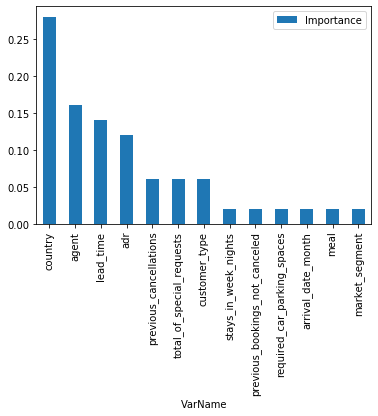

In [14]:
#Construimos un primer dataframe con las variables numéricas:
search_values = num_features
imp_df_num = imp_df_raw[imp_df_raw.VarName.str.contains('|'.join(search_values ))].copy()

#Juntamos todas las categorías de las variables categóricas:

arrival_date_month = imp_df_raw[imp_df_raw['VarName'].str.contains("arrival_date_month")]
meal = imp_df_raw[imp_df_raw['VarName'].str.contains("meal")]
country = imp_df_raw[imp_df_raw['VarName'].str.contains("country")]
market_segment = imp_df_raw[imp_df_raw['VarName'].str.contains("market_segment")]

customer_type = imp_df_raw[imp_df_raw['VarName'].str.contains("customer")]

#Creamos un array con las sumas:
array = np.zeros(shape=(5,1))

array[0] = arrival_date_month.Importance.sum()
array[1] = meal.Importance.sum()
array[2] = country.Importance.sum()
array[3] = market_segment.Importance.sum()

array[4] = customer_type.Importance.sum()

#Construimos un diccionario para crear un dataframe con las variables categóricas fácilmente:
dict = {'VarName': [
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'customer_type']
                 , 'Importance': array[:,0]}

imp_dict = pd.DataFrame(dict)

#Unimos los dos dataframes:
imp_df_final = imp_df_num.append(imp_dict,ignore_index = True)
imp_df_final.head(22)
imp_df_final.sort_values(by = 'Importance', ascending=False).head(22).plot.bar(x = 'VarName')

Reducimos mas los atributos, quedandonos unicamente los 4 mejores atributos

In [15]:
#Definimos que variables son númericas y cuales son categóricas:
num_features = ["lead_time","agent","adr"]
,
cat_features = ["country"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Prepararamos el preprocesado. Escalaremos las variables numéricas y codificaremos las variables categóricas:
num_transformer = StandardScaler()
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
#Definimos el modelo a usar:
ab_model = AdaBoostClassifier()

#Usaremos 10-fold stratified CV. Al usar pipelines nos aseguramos que los datos se transformen en cada iteración.
kfold = KFold(n_splits=10, random_state=100, shuffle = True)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', ab_model)])
cv_results = cross_validate(model_pipe, 
                                 X_train, y_train, 
                                 cv=kfold,
                                 scoring={'accuracy': 'accuracy','balanced_accuracy': 'balanced_accuracy','roc_auc': 'roc_auc','tp': make_scorer(tp), 'tn': make_scorer(tn),
'fp': make_scorer(fp), 'fn': make_scorer(fn)},
                                 n_jobs=-1)
#Mostramos los resultados:
model_results_ab4 = np.zeros(shape=(1,7))
accuracy_array =  cv_results['test_accuracy']
balanced_accuracy_array =  cv_results['test_balanced_accuracy']
roc_auc_array = cv_results['test_roc_auc']


min_score_acc = round(min(accuracy_array), 4)
max_score_acc = round(max(accuracy_array), 4)
mean_score_acc = round(np.mean(accuracy_array), 4)
std_dev_acc = round(np.std(accuracy_array), 4)

min_score_bal_acc = round(min(balanced_accuracy_array), 4)
max_score_bal_acc = round(max(balanced_accuracy_array), 4)
mean_score_bal_acc = round(np.mean(balanced_accuracy_array), 4)
std_dev_bal_acc = round(np.std(balanced_accuracy_array), 4)

min_score_roc_auc = round(min(roc_auc_array), 4)
max_score_roc_auc = round(max(roc_auc_array), 4)
mean_score_roc_auc = round(np.mean(roc_auc_array), 4)
std_dev_roc_auc = round(np.std(roc_auc_array), 4)

sensitivity = np.zeros(shape=(1,10))
specificity = np.zeros(shape=(1,10))
precision = np.zeros(shape=(1,10))
NPV = np.zeros(shape=(1,10))
FNR = np.zeros(shape=(1,10))
FPR = np.zeros(shape=(1,10))
F1 = np.zeros(shape=(1,10))

#Construimos la matriz de confusión:
cm_ab4 = np.zeros(shape=(2,2))

tp_array = cv_results['test_tp']
tn_array = cv_results['test_tn']
fp_array = cv_results['test_fp']
fn_array = cv_results['test_fn']
    
tn_mean = (tn_array.mean()).astype(np.int64)
fp_mean = (fp_array.mean()).astype(np.int64)
fn_mean = (fn_array.mean()).astype(np.int64)
tp_mean = (tp_array.mean()).astype(np.int64)

cm_ab4[0] = [tn_mean, fp_mean]
cm_ab4[1] = [fn_mean, tp_mean]

j=0
while j < 10:
    sensitivity[0,j] = tp_array[j]/(tp_array[j]+fn_array[j])
    specificity[0,j] = tn_array[j]/(tn_array[j]+fp_array[j])
    precision[0,j] = tp_array[j]/(tp_array[j]+fp_array[j])
    NPV[0,j] = tn_array[j]/(tn_array[j]+fn_array[j])
    FNR[0,j] = 1-tp_array[j]/(tp_array[j]+fn_array[j])
    FPR[0,j] = 1-tn_array[j]/(tn_array[j]+fp_array[j])
    F1[0,j] = 2*tp_array[j]/(2*tp_array[j]+fp_array[j]+fn_array[j])
    j=j+1
    
        
sd_sensitivity = round(np.std(sensitivity), 4)
sd_specificity = round(np.std(specificity), 4)
sd_precision = round(np.std(precision), 4)
sd_NPV = round(np.std(NPV), 4)
sd_FNR = round(np.std(FNR), 4)
sd_FPR = round(np.std(FPR), 4)
sd_F1 = round(np.std(F1), 4)
    
sensitivity_mean = round(sensitivity.mean(),4)
specificity_mean = round(specificity.mean(),4)
precision_mean = round(precision.mean(),4)
NPV_mean = round(NPV.mean(),4)
FNR_mean = round(FNR.mean(),4)
FPR_mean = round(FPR.mean(),4)
F1_mean = round(F1.mean(),4)


model_results_ab4 = np.array([mean_score_acc,mean_score_bal_acc,mean_score_roc_auc,tn_mean,fp_mean,fn_mean,tp_mean])

print(f"Adaboost accuracy score: {mean_score_acc} +/- {std_dev_acc} (std) min: {min_score_acc}, max: {max_score_acc}")
print(f"Adaboost balanced accuracy score: {mean_score_bal_acc} +/- {std_dev_bal_acc} (std) min: {min_score_bal_acc}, max: {max_score_bal_acc}")
print(f"Adaboost area under ROC curve score: {mean_score_roc_auc} +/- {std_dev_roc_auc} (std) min: {min_score_roc_auc}, max: {max_score_roc_auc}")
print(f"Adaboost cross validation sensitivity score: {sensitivity_mean} +/- {sd_sensitivity} (std)")
print(f"Adaboost cross validation specificity score: {specificity_mean} +/- {sd_specificity} (std)")
print(f"Adaboost cross validation precision score: {precision_mean} +/- {sd_precision} (std)")
print(f"Adaboost cross validation NPV score: {NPV_mean} +/- {sd_NPV} (std)")
print(f"Adaboost cross validation FNR score: {FNR_mean} +/- {sd_FNR} (std)")
print(f"Adaboost cross validation FPR score: {FPR_mean} +/- {sd_FPR} (std)")
print(f"Adaboost cross validation F1 score: {F1_mean} +/- {sd_F1} (std)")
print(cm_ab4)

Adaboost accuracy score: 0.7479 +/- 0.0055 (std) min: 0.7389, max: 0.755
Adaboost balanced accuracy score: 0.7363 +/- 0.0066 (std) min: 0.724, max: 0.7444
Adaboost area under ROC curve score: 0.8284 +/- 0.0068 (std) min: 0.8146, max: 0.8388
Adaboost cross validation sensitivity score: 0.6497 +/- 0.0116 (std)
Adaboost cross validation specificity score: 0.8229 +/- 0.0087 (std)
Adaboost cross validation precision score: 0.7367 +/- 0.0148 (std)
Adaboost cross validation NPV score: 0.7549 +/- 0.0064 (std)
Adaboost cross validation FNR score: 0.3503 +/- 0.0116 (std)
Adaboost cross validation FPR score: 0.1771 +/- 0.0087 (std)
Adaboost cross validation F1 score: 0.6904 +/- 0.0103 (std)
[[1969.  424.]
 [ 639. 1187.]]


Miraremos ahora la importancia de los atributos:

In [16]:
#Ajustamos el modelo para poder acceder a los valores:
model_pipe.fit(X_train,y_train)

#Necesitamos los nombres de los atributos codificados. Los obtenemos de One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#Añadimos los atributos numéricos para tener la lista de atributos completa
feat_imp_list = num_features + onehot_columns

#Calculamos la importancia de cada variable:
feature_importances = model_pipe['model'].feature_importances_

# variable importance: 
imp = {"VarName":feat_imp_list
       , "Importance":feature_importances}


imp_df_raw = pd.DataFrame(imp)

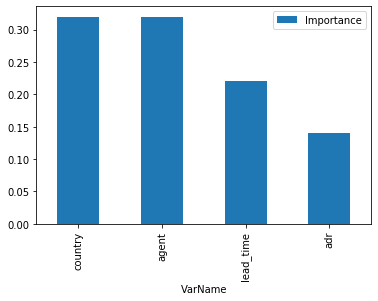

In [17]:
#Construimos un primer dataframe con las variables numéricas:
search_values = num_features
imp_df_num = imp_df_raw[imp_df_raw.VarName.str.contains('|'.join(search_values ))].copy()

#Juntamos todas las categorías de las variables categóricas:


country = imp_df_raw[imp_df_raw['VarName'].str.contains("country")]


#Creamos un array con las sumas:
array = np.zeros(shape=(1,1))
array[0] = country.Importance.sum()


#Construimos un diccionario para crear un dataframe con las variables categóricas fácilmente:
dict = {'VarName': ['country']
                 , 'Importance': array[:,0]}

imp_dict = pd.DataFrame(dict)

#Unimos los dos dataframes:
imp_df_final = imp_df_num.append(imp_dict,ignore_index = True)
imp_df_final.head(22)
imp_df_final.sort_values(by = 'Importance', ascending=False).head(22).plot.bar(x = 'VarName')

In [20]:
#Juntamos los resultados obtenidos con cada modelo:
adaboost_parameters = np.zeros(shape=(3,7))
adaboost_parameters[0] = model_results_ab22
adaboost_parameters[1] = model_results_ab13
adaboost_parameters[2] = model_results_ab4

#Creamos un diccionario para pasar los resultados a un dataframe:
adaboost_parameters_dict = {'Model': ['Adaboost 22 var', 'Adaboost 13 var', 'Adaboost 4 var']
                 , 'Accuracy': adaboost_parameters[:,0],'Balanced accuracy': adaboost_parameters[:,1],'ROC AUC': adaboost_parameters[:,2],'TN': adaboost_parameters[:,3],'FP': adaboost_parameters[:,4],'FN': adaboost_parameters[:,5],'TP': adaboost_parameters[:,6]}

adaboost_parameters_df = pd.DataFrame.from_dict(adaboost_parameters_dict)
adaboost_parameters_df

,Model,Accuracy,Balanced accuracy,ROC AUC,TN,FP,FN,TP
0,Adaboost 22 var,0.8113,0.8026,0.8935,2075.0,318.0,478.0,1348.0
1,Adaboost 13 var,0.8111,0.8024,0.8937,2075.0,318.0,478.0,1348.0
2,Adaboost 4 var,0.7479,0.7363,0.8284,1969.0,424.0,639.0,1187.0


Text(0.5, 1.0, 'Area under ROC curve VS # of variables')

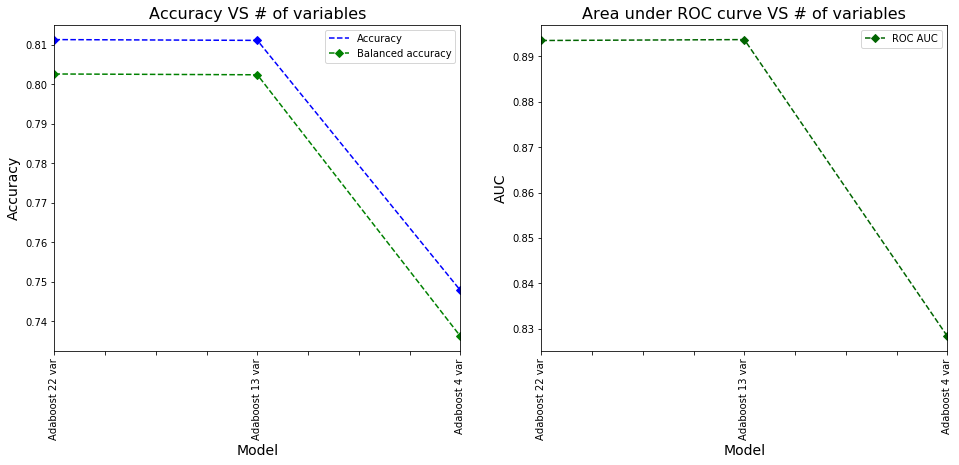

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,6))
a = adaboost_parameters_df.plot(kind='line',x='Model',y='Accuracy',ax=ax1, rot = 90, color = 'blue',linestyle ='--', marker='D')
adaboost_parameters_df.plot(kind='line',x='Model',y='Balanced accuracy', color='green', ax=ax1, rot = 90,linestyle ='--', marker='D')
a.set_title('Accuracy VS # of variables', fontsize = 16)
a.set_xlabel('Model', fontsize = 14)
a.set_ylabel('Accuracy', fontsize = 14)

b = adaboost_parameters_df.plot(kind='line',x='Model',y='ROC AUC', rot = 90, color = 'DarkGreen',linestyle ='--', marker='D',ax=ax2)
b.set_xlabel('Model', fontsize = 14)
b.set_ylabel('AUC', fontsize = 14)
plt.title('Area under ROC curve VS # of variables', fontsize = 16)

Nos quedamos con el modelo de 13 variables.

### 9.3 Ajustar hiperparametros

In [22]:
#Nos hemos quedado con el modelo de 13 variables

num_features = ["lead_time","stays_in_week_nights","previous_cancellations","previous_bookings_not_canceled","agent","adr","required_car_parking_spaces","total_of_special_requests",
               ]
,
cat_features = ["arrival_date_month","meal","country","market_segment","customer_type"]

features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]


#Codificamos las variables categóricas:
ct = make_column_transformer(
    (OneHotEncoder(),cat_features), remainder = 'passthrough')

#Convertimos X en un array:
X = ct.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [23]:
X_train.shape

(42209, 200)

#### 9.3.1 n_estimators

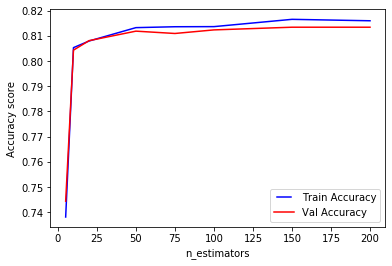

In [25]:
estimadores = [5,10,20,50,75,100,150,200]
train_results = []
test_results = []
for estimador in estimadores:
    dt = AdaBoostClassifier(n_estimators=estimador)
    dt.fit(X_train, y_train)
    score=dt.score(X_train, y_train)
    # Add auc score to previous train results
    train_results.append(score)
    scoret = dt.score(X_val, y_val)
    # Add auc score to previous test results
    test_results.append(scoret)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(estimadores, train_results, "b", label="Train Accuracy")
line2, = plt.plot(estimadores, test_results, "r", label="Val Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("n_estimators")
plt.show()

iteracion 5 realizada
iteracion 10 realizada
iteracion 20 realizada
iteracion 50 realizada
iteracion 75 realizada


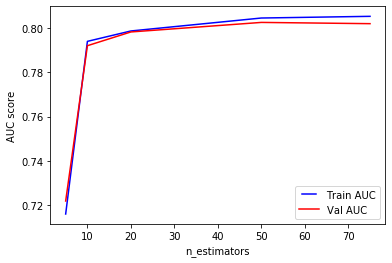

In [26]:
estimadores = [5,10,20,50,75]
train_results = []
test_results = []
for estimador in estimadores:
    dt = AdaBoostClassifier(n_estimators=estimador)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    print("iteracion", estimador, "realizada")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(estimadores, train_results, "b", label="Train AUC")
line2, = plt.plot(estimadores, test_results, "r", label="Val AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

Nos quedamos con el valor el valor n_estimadors=100.

#### 9.3.2 learning_rate

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
2
3
4
5


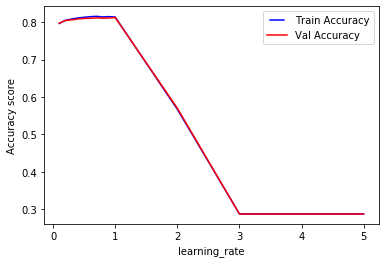

In [27]:
learning_rates = [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4,5]
train_results = []
test_results = []
for learning_rate1 in learning_rates:
    dt = AdaBoostClassifier(learning_rate=learning_rate1, n_estimators=100 )
    dt.fit(X_train, y_train)
    score=dt.score(X_train, y_train)
    # Add auc score to previous train results
    train_results.append(score)
    scoret = dt.score(X_val, y_val)
    # Add auc score to previous test results
    test_results.append(scoret)
    print(learning_rate1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, "b", label="Train Accuracy")
line2, = plt.plot(learning_rates, test_results, "r", label="Val Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("learning_rate")
plt.show()

iteracion 0.1 realizada
iteracion 0.2 realizada
iteracion 0.3 realizada
iteracion 0.4 realizada
iteracion 0.5 realizada
iteracion 0.6 realizada
iteracion 0.7 realizada
iteracion 0.8 realizada
iteracion 0.9 realizada
iteracion 1 realizada
iteracion 2 realizada
iteracion 3 realizada
iteracion 4 realizada
iteracion 5 realizada


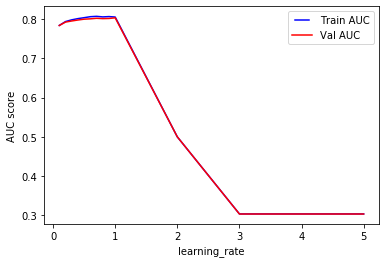

In [41]:
learning_rates = [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4,5]
train_results = []
test_results = []
for learning_rate1 in learning_rates:
    dt = AdaBoostClassifier(learning_rate=learning_rate1, n_estimators= 100)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    print("iteracion", learning_rate1, "realizada")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, "b", label="Train AUC")
line2, = plt.plot(learning_rates, test_results, "r", label="Val AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("learning_rate")
plt.show()

In [49]:
grid_param = {'n_estimators': [5,10,20,50,75,100,150,200], 'learning_rate': [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4,5]}
gd_sr = sklearn.model_selection.GridSearchCV(estimator=AdaBoostClassifier(),
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=2,
                     n_jobs=-1)
gd_sr.fit(X_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'learning_rate': 0.9, 'n_estimators': 200}


### 9.4 Modelo final

In [29]:
ab_final_model = AdaBoostClassifier(learning_rate=1, n_estimators=100)
ab_final_model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=None)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [31]:
ab_final_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=None)

In [32]:
#Calculamos los valores que obtenemos de nuestros datos de test
y_pred=ab_final_model.predict(X_test)

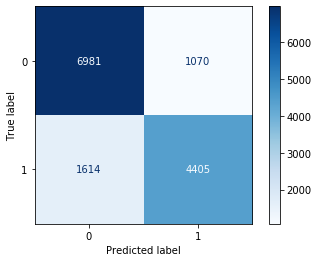

In [33]:
sklearn.metrics.plot_confusion_matrix(ab_final_model, X_test, y_test, values_format="d", cmap=plt.cm.Blues)  # doctest: +SKIP
plt.show()

In [36]:
import sklearn.metrics as metrics
accuracy= sklearn.metrics.accuracy_score(y_test, y_pred)
accuracy_balanced= sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
probs = ab_final_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc= metrics.auc(fpr, tpr)
f1= sklearn.metrics.f1_score(y_test, y_pred)

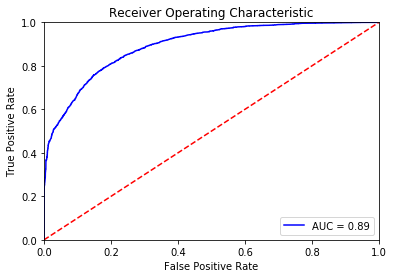

In [37]:
import sklearn.metrics as metrics
probs = ab_final_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc= metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      8051
           1       0.80      0.73      0.77      6019

    accuracy                           0.81     14070
   macro avg       0.81      0.80      0.80     14070
weighted avg       0.81      0.81      0.81     14070



In [39]:
results_dict = {'Model': ['Adaboost']
                 , 'Accuracy': accuracy,'Balanced accuracy': accuracy_balanced,'ROC AUC': roc, 'F1 Score': f1, 'sensitivity':0.73, 'specificity':0.87}

model_results_df = pd.DataFrame.from_dict(results_dict)
model_results_df

,Model,Accuracy,Balanced accuracy,ROC AUC,F1 Score,sensitivity,specificity
0,Adaboost,0.80924,0.799473,0.894435,0.766487,0.73,0.87


In [40]:
model_results_df.to_csv('df_Adaboost_final.csv', index=False)